In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plot_params import *
from pathlib import Path
import numpy as np
circ_quant_output = []

indir = '/tscc/nfs/home/s5xu/scratch/circSTAMP_pipe/1_basic_nextera/output'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
indir = '/tscc/nfs/home/s5xu/scratch/circSTAMP_pipe/1_basic_trueseq/output'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]

In [2]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [3]:
rename_dict = {
               #### included
               'HEK_rep1_rar11': 'SD_seq_rep1',
               'HEK_rep2_rar11': 'SD_seq_rep2',
               'rar_rep1': 'rar_rep1',
               'rar_rep2': 'rar_rep2', 
               'arr_rep1': 'arr_rep1', 
               'arr_rep2':'arr_rep2',
               'rz_rep1': 'rz_rep1', 
               'rz_rep2':'rz_rep2',
               ### included
               }
group_color = {
              'SD_seq': 'orange',
              
              'rz': 'mediumorchid', 
              'rar': 'seagreen',
              'arr': 'royalblue'}

In [4]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
mega_anno = []

features = ['seqname', 'start', 'end', 
       'strand', 'circ_type', 'gene_id', 'gene_name', 'gene_type']
for fname in circ_quant_output:
    
    
    name = os.path.basename(fname).replace('.gtf', '')
    if name in rename_dict.keys():
        names.append(name)

        circ_df, stat = read_ciri_gtf(fname)

        circ_type_count.append(circ_df['circ_type'].value_counts())

        junc_ratio_tbl.append(circ_df.set_index('circ_id')['junc_ratio'].astype(float))
        bsj_ratio_tbl.append(circ_df.set_index('circ_id')['bsj'].astype(float))
        fsj_ratio_tbl.append(circ_df.set_index('circ_id')['fsj'].astype(float))
        stats.append(stat.set_index(0))
        
        
        
    
        mega_anno.append(circ_df.set_index('circ_id')[features])
mega_anno = pd.concat(mega_anno, axis = 0).drop_duplicates()


In [5]:
stats_df = pd.concat(stats, axis = 1).T
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)

stats_df = stats_df.drop_duplicates('##Sample').set_index('##Sample')
stats_df = stats_df.rename(rename_dict).sort_index()
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']

names = [rename_dict[c] if c in rename_dict.keys() else c for c in names ]



In [6]:
counts = pd.concat(circ_type_count, axis = 1)
counts.columns = names
counts = counts.T.reset_index().drop_duplicates('index').set_index('index')

In [7]:
bsj = pd.concat(bsj_ratio_tbl, axis = 1)
bsj.columns = names
bsj=bsj.T.reset_index().drop_duplicates('index').set_index('index').T
fsj = pd.concat(fsj_ratio_tbl, axis = 1)
fsj.columns = names
fsj=fsj.T.reset_index().drop_duplicates('index').set_index('index').T
junc = pd.concat(junc_ratio_tbl, axis = 1)
junc.columns = names
junc=junc.T.reset_index().drop_duplicates('index').set_index('index').T

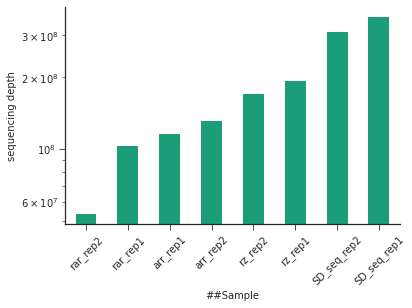

In [8]:
stats_df['##Total_Reads'].sort_values().plot.bar()
plt.ylabel('sequencing depth')
plt.yscale('log')
plt.xticks(rotation=45)
sns.despine()

In [9]:
figure1_sets = [ 
              'rz_rep1','rz_rep2',
             'arr_rep1','arr_rep2',
              'rar_rep1', 'rar_rep2',
              'SD_seq_rep1','SD_seq_rep2'
             ]

In [10]:
figure1_colors = [group_color[c.split('-')[0].split('_rep')[0]] for c in figure1_sets]

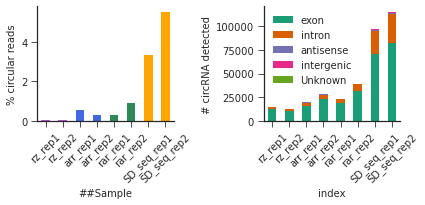

In [11]:
f, ax = plt.subplots(1,2, figsize = (6,3))
(stats_df.loc[figure1_sets, 'frac_circular']*100).plot.bar(
    color = figure1_colors, ax = ax[0])
ax[0].set_ylabel('% circular reads')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45) 



counts.loc[figure1_sets].plot.bar(stacked = True, ax = ax[1])
ax[1].set_ylabel('# circRNA detected')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45) 
sns.despine()
plt.tight_layout()
plt.savefig(figdir / f"1_perc_circle.pdf")

# Enrichment as measured by junction ratio

In [12]:
from scipy.stats import pearsonr

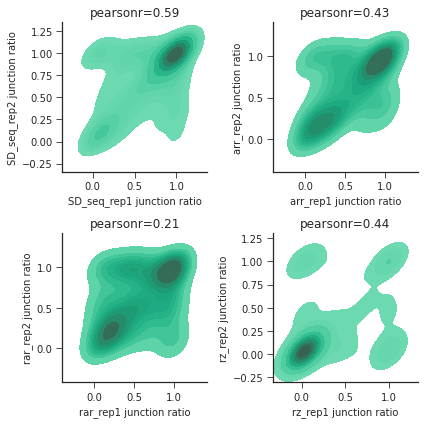

In [13]:
f, axes = plt.subplots(2,2, figsize = (6,6))
sub_junc = junc.loc[~(junc['rz_rep1'].isnull())&~(junc['rz_rep2'].isnull())]

for protocol, ax in zip(['SD_seq', 'arr', 'rar', 'rz'], axes.flatten()):
    sns.kdeplot(data = sub_junc.sample(500), x = f'{protocol}_rep1', y = f'{protocol}_rep2', fill = True, ax = ax)
    r,p = pearsonr(sub_junc[f'{protocol}_rep1'].fillna(0),sub_junc[f'{protocol}_rep2'].fillna(0))
    ax.set_title(f'pearsonr={r:.2f}')
    ax.set_xlabel(f'{protocol}_rep1 junction ratio')
    ax.set_ylabel(f'{protocol}_rep2 junction ratio')
# sns.kdeplot(data = sub_junc.sample(500), x = 'arr_rep1', y = 'arr_rep2', fill = True, ax = ax[0,1])
# sns.kdeplot(data = sub_junc.sample(500), x = 'rar_rep1', y = 'rar_rep2', fill = True, ax = ax[1,0])
# sns.kdeplot(data = sub_junc.sample(500), x = 'rz_rep1', y = 'rz_rep2', fill = True, ax = ax[1,1])
sns.despine()
plt.tight_layout()
# plt.savefig(figdir / '1_junc_ratio_reproducibility.pdf')

In [14]:
sub_junc_t = sub_junc.T.copy()
sub_junc_t['protocol']=pd.Series(sub_junc.columns).str.split('_', expand = True)[0].tolist()
avg_junc = sub_junc_t.groupby(by = 'protocol').mean().T

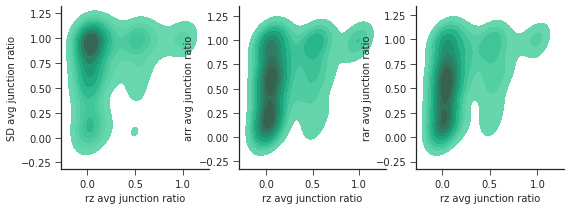

In [15]:
f, axes = plt.subplots(1,3, figsize = (9,3))
for protocol, ax in zip(['SD', 'arr', 'rar'], axes):
    
    sns.kdeplot(data = avg_junc.sample(500), x = f'rz', y = f'{protocol}', fill = True, ax = ax)
    ax.set_xlabel(f'rz avg junction ratio')
    ax.set_ylabel(f'{protocol} avg junction ratio')
    
    #r,p = pearsonr(sub_junc[f'{protocol}_rep1'].fillna(0),sub_junc[f'{protocol}_rep2'].fillna(0))
    #ax.set_title(f'pearsonr={r:.2f}')
sns.despine()
plt.savefig(figdir / '1_junc_ratio_vs_rz.pdf')

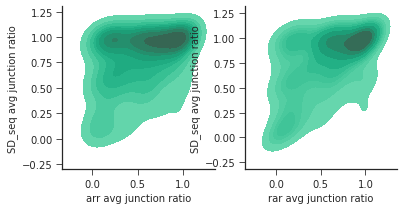

In [16]:
f, axes = plt.subplots(1,2, figsize = (6,3))
for protocol, ax in zip(['arr', 'rar'], axes):
    
    sns.kdeplot(data = avg_junc.sample(500), y = f'SD', x = f'{protocol}', fill = True, ax = ax)
    ax.set_ylabel(f'SD_seq avg junction ratio')
    ax.set_xlabel(f'{protocol} avg junction ratio')
    
    #r,p = pearsonr(sub_junc[f'{protocol}_rep1'].fillna(0),sub_junc[f'{protocol}_rep2'].fillna(0))
    #ax.set_title(f'pearsonr={r:.2f}')
sns.despine()
# plt.savefig(figdir / '1_junc_ratio_vs_other.pdf')

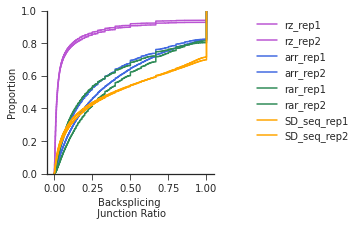

In [17]:
f, ax = plt.subplots(figsize = (3,3))
for col, color in zip(figure1_sets, figure1_colors):
    ax = sns.ecdfplot(data =junc[col].to_frame(), x = col, ax = ax, label = col, color = color)
    ax.set_xlabel('Backsplicing \n Junction Ratio')
ax.legend(bbox_to_anchor = (1.2,1))
#sns.move_legend(ax, "center right")
sns.despine()

In [18]:
avg_junc.loc[avg_junc['rz']>0, 'rz'].min()

0.0005

In [19]:
group_color = {
              'SD_seq': 'orange',
              
              'rz': 'mediumorchid', 
              'rar': 'seagreen',
              'arr': 'royalblue'}

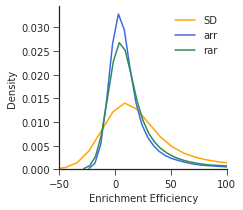

In [20]:
enrichment_eff = avg_junc.loc[avg_junc['rz']>0].div(avg_junc.loc[avg_junc['rz']>0, 'rz'], axis = 0)
f, ax = plt.subplots(figsize = (3,3))
for protocol, c in zip(['SD', 'arr', 'rar'], ['orange', 'royalblue', 'seagreen']):
    sns.kdeplot(data = enrichment_eff.fillna(0), x = protocol, label = protocol, ax = ax,
               color = c)
ax.legend()
ax.set_xlabel('Enrichment Efficiency')
ax.set_xlim(-50,100)
sns.despine()
plt.savefig(figdir / '1_enrichment_eff.pdf')

# Accuracy

In [21]:
circname = {}
for name in bsj.columns:
    circname[name] = set(bsj[name].dropna().index)

In [22]:
circname_reproducible = {}
for protocol in ['SD_seq', 'arr', 'rar', 'rz']:
    circname_reproducible[protocol]=circname[f'{protocol}_rep1'].intersection(circname[f'{protocol}_rep2'])

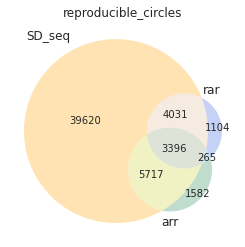

In [23]:
from matplotlib_venn import venn3
venn3([circname_reproducible[p] for p in ['SD_seq', 'arr', 'rar']]
      , set_labels = ('SD_seq', 'rar', 'arr'), 
      set_colors = (group_color[p] for p in ['SD_seq', 'arr', 'rar']),
      alpha = 0.3
     )
plt.title('reproducible_circles')
plt.savefig(figdir / '1_venn_3procotol.pdf')

In [24]:
# from venny4py.venny4py import *
# venny4py(circname_reproducible)
# # plt.savefig(figdir / '1_venn_4procotol.pdf')

In [25]:
from scipy.stats import pearsonr
def get_pearsonr_dropna(df, col1, col2):
    sub = df[[col1, col2]].dropna()
    r,p=pearsonr(sub[col1], sub[col2])
    return r,p

In [26]:
cpm=bsj.div(stats_df['##Total_Reads'], axis = 1)*10**6

In [27]:
cpm.shape, bsj.shape

((189119, 8), (189119, 8))

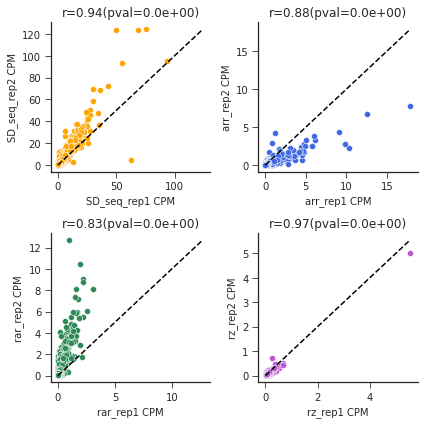

In [28]:
f, axes = plt.subplots(2,2, figsize = (6,6))
for protocol, ax in zip(['SD_seq', 'arr', 'rar', 'rz'], axes.flatten()):

    sns.scatterplot(data = cpm.dropna(subset = [f'{protocol}_rep1',f'{protocol}_rep2']), x = f'{protocol}_rep1', y = f'{protocol}_rep2', ax = ax, 
                     color = group_color[protocol])#, marker = '.')
    r,p = get_pearsonr_dropna(cpm, f'{protocol}_rep1', f'{protocol}_rep2')
    ax.set_title(f'r={r:.2f}(pval={p:.1e})')
    ax.set_xlabel(f'{protocol}_rep1 CPM')
    ax.set_ylabel(f'{protocol}_rep2 CPM')
    ax.plot([0, max(cpm[f'{protocol}_rep1'].max(), cpm[f'{protocol}_rep2'].max())],
            [0, max(cpm[f'{protocol}_rep1'].max(), cpm[f'{protocol}_rep2'].max())],
            '--',
           color = 'black'
           )


plt.tight_layout()
sns.despine()
plt.savefig(figdir/f"1_CPM_reproducibility.png")

<AxesSubplot:xlabel='rz_rep1', ylabel='rz_rep2'>

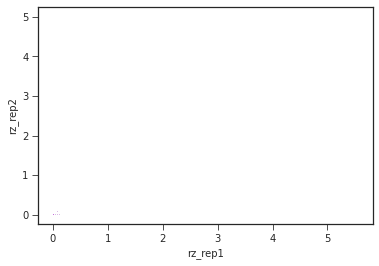

In [29]:
sns.histplot(data = cpm.dropna(subset = [f'{protocol}_rep1',f'{protocol}_rep2']), 
             x = f'{protocol}_rep1', y = f'{protocol}_rep2' ,
                     color = group_color[protocol])#, marker = '.')

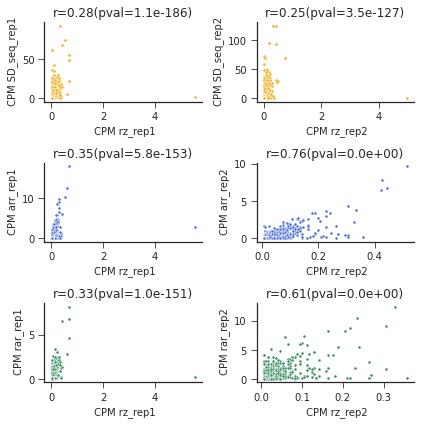

In [30]:
f, axes = plt.subplots(3,2, figsize = (6,6))
for i, protocol in enumerate(['SD_seq', 'arr', 'rar']):
    for j, rep in enumerate([1,2]):
        ax = axes[i,j]
        x = f'rz_rep{rep}'
        y = f'{protocol}_rep{rep}'
        sns.scatterplot(data = cpm, x = x, y = y, ax = ax, 
                         color = group_color[protocol], marker = '.')
        r,p = get_pearsonr_dropna(cpm, x,y)
        ax.set_title(f'r={r:.2f}(pval={p:.1e})')
        ax.set_xlabel(f' CPM {x}')
        ax.set_ylabel(f' CPM {y}')
        # ax.plot([0, max(cpm[f'{protocol}_rep{rep}'].max(), cpm[f'rz_rep{rep}'].max())],
        #         [0, max(cpm[f'{protocol}_rep{rep}'].max(), cpm[f'rz_rep{rep}'].max())],
        #         '--',
        #        color = 'black'
        #        )


plt.tight_layout()
sns.despine()
# plt.savefig(figdir / '1_CPM_compareto_rz_eachrep.pdf')

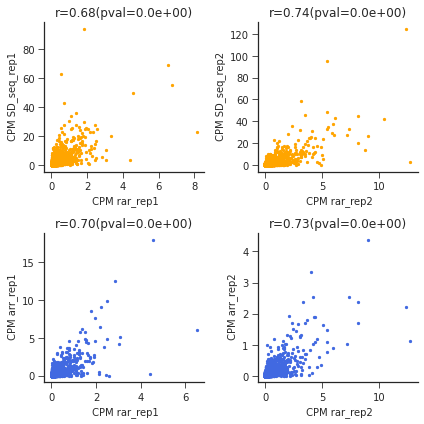

In [31]:
f, axes = plt.subplots(2,2, figsize = (6,6))
for i, protocol in enumerate(['SD_seq', 'arr']):
    for j, rep in enumerate([1,2]):
        ax = axes[i,j]
        x = f'rar_rep{rep}'
        y = f'{protocol}_rep{rep}'
        cpm.plot.scatter(x = x, y = y, ax = ax, 
                         color = group_color[protocol], marker = '.')
        r,p = get_pearsonr_dropna(cpm, x,y)
        ax.set_title(f'r={r:.2f}(pval={p:.1e})')
        ax.set_xlabel(f' CPM {x}')
        ax.set_ylabel(f' CPM {y}')
        # ax.plot([0, max(cpm[f'{protocol}_rep{rep}'].max(), cpm[f'rz_rep{rep}'].max())],
        #         [0, max(cpm[f'{protocol}_rep{rep}'].max(), cpm[f'rz_rep{rep}'].max())],
        #         '--',
        #        color = 'black'
        #        )


plt.tight_layout()
sns.despine()
# plt.savefig(figdir / '1_CPM_compareto_rar_eachrep.pdf')

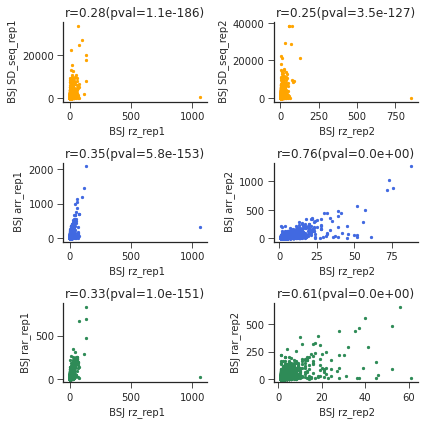

In [32]:
f, axes = plt.subplots(3,2, figsize = (6,6))
for i, protocol in enumerate(['SD_seq', 'arr', 'rar']):
    for j, rep in enumerate([1,2]):
        ax = axes[i,j]
        x = f'rz_rep{rep}'
        y = f'{protocol}_rep{rep}'
        bsj.plot.scatter(x = x, y = y, ax = ax, 
                         color = group_color[protocol], marker = '.')
        r,p = get_pearsonr_dropna(bsj, x,y)
        ax.set_title(f'r={r:.2f}(pval={p:.1e})')
        ax.set_xlabel(f' BSJ {x}')
        ax.set_ylabel(f' BSJ {y}')
        # ax.plot([0, max(cpm[f'{protocol}_rep{rep}'].max(), cpm[f'rz_rep{rep}'].max())],
        #         [0, max(cpm[f'{protocol}_rep{rep}'].max(), cpm[f'rz_rep{rep}'].max())],
        #         '--',
        #        color = 'black'
        #        )


plt.tight_layout()
sns.despine()
# plt.savefig(figdir / '1_BSJ_compareto_rz_eachrep.pdf')

In [33]:
cpm_t = cpm.loc[(cpm['rz_rep1']>0)&(cpm['rz_rep2']>0)].T.copy()
cpm_t['protocol']=pd.Series(cpm.columns).str.split('_', expand = True)[0].tolist()
avg_cpm = cpm_t.groupby(by = 'protocol').mean().T

In [34]:
group_color['SD'] = 'orange'

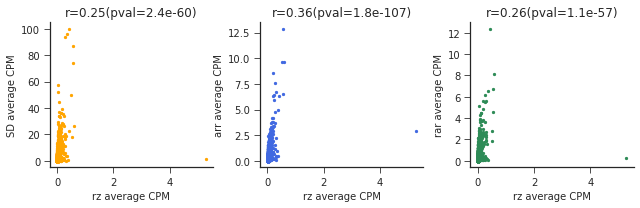

In [35]:
f, axes = plt.subplots(1,3, figsize = (9,3))
for protocol, ax in zip(['SD', 'arr', 'rar'], axes.flatten()):

    avg_cpm.plot.scatter(y = f'{protocol}', x = f'rz', ax = ax, 
                     color = group_color[protocol], marker = '.')
    r,p = get_pearsonr_dropna(avg_cpm, f'{protocol}', f'rz')
    ax.set_title(f'r={r:.2f}(pval={p:.1e})')
    ax.set_xlabel(f'rz average CPM')
    ax.set_ylabel(f'{protocol} average CPM')


plt.tight_layout()
sns.despine()
plt.savefig(figdir / '1_CPM_corr_w_rz.pdf')

<AxesSubplot:>

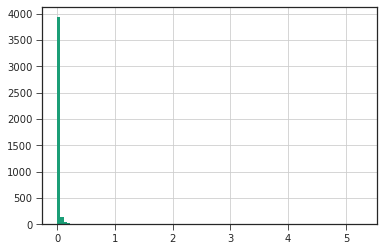

In [36]:
avg_cpm['rz'].hist(bins = 100)

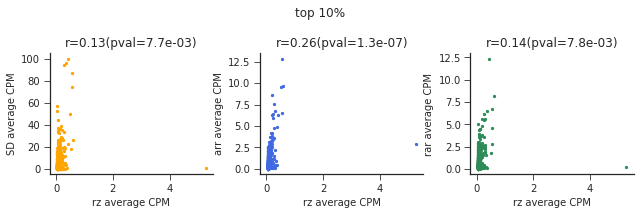

In [37]:
# Gene said to show top 10% for correlation
top10percent = np.percentile(avg_cpm['rz'], 90)
f, axes = plt.subplots(1,3, figsize = (9,3))
for protocol, ax in zip(['SD', 'arr', 'rar'], axes.flatten()):

    avg_cpm.loc[avg_cpm['rz']>top10percent].plot.scatter(y = f'{protocol}', x = f'rz', ax = ax, 
                     color = group_color[protocol], marker = '.')
    r,p = get_pearsonr_dropna(avg_cpm.loc[avg_cpm['rz']>top10percent], f'{protocol}', f'rz')
    ax.set_title(f'r={r:.2f}(pval={p:.1e})')
    ax.set_xlabel(f'rz average CPM')
    ax.set_ylabel(f'{protocol} average CPM')

plt.suptitle('top 10%')
plt.tight_layout()
sns.despine()
# plt.savefig(figdir / '1_CPM_corr_w_rz_top10_percent.pdf')

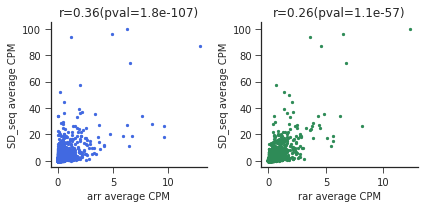

In [38]:
f, axes = plt.subplots(1,2, figsize = (6,3))
for protocol, ax in zip(['arr', 'rar'], axes.flatten()):

    avg_cpm.plot.scatter(x = f'{protocol}', y = f'SD', ax = ax, 
                     color = group_color[protocol], marker = '.')
    r,p = get_pearsonr_dropna(avg_cpm, f'{protocol}', f'rz')
    ax.set_title(f'r={r:.2f}(pval={p:.1e})')
    ax.set_ylabel(f'SD_seq average CPM')
    ax.set_xlabel(f'{protocol} average CPM')


plt.tight_layout()
sns.despine()
plt.savefig(figdir / '1_CPM_corr_w_other.pdf')

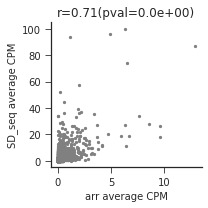

In [39]:
f, ax = plt.subplots(figsize = (3,3))
avg_cpm.plot.scatter(x = f'arr', y = f'SD', ax = ax, 
                     color = 'grey', marker = '.')
r,p = get_pearsonr_dropna(avg_cpm, f'arr', f'rar')
ax.set_title(f'r={r:.2f}(pval={p:.1e})')
ax.set_xlabel(f'arr average CPM')
ax.set_ylabel(f'SD_seq average CPM')
plt.tight_layout()
sns.despine()
# plt.savefig(figdir / '1_rar_corr_arr.pdf')

In [40]:
mionco_df = pd.read_csv('/tscc/projects/ps-yeolab5/hsher/mioncocirc/v0.1.release.txt', sep = '\t')
mionco_df['circ_id']=mionco_df['chr']+':'+(mionco_df['start']+1).astype(str)+'|'+mionco_df['end'].astype(str)

In [41]:

detected_t = ~bsj.isnull().T
detected_t['protocol']=pd.Series(bsj.columns).str.split('_', expand = True)[0].tolist()
detected_both = detected_t.groupby(by = 'protocol').all().T
detected_both.columns = ['detected_'+c for c in detected_both.columns]

In [42]:
mega = pd.concat([detected_both, cpm, mega_anno], axis = 1)

In [43]:
mega['is_miOncoCirc']=mega.index.isin(mionco_df['circ_id'])

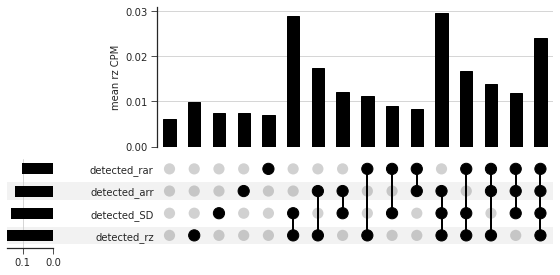

In [44]:
from upsetplot import plot
plot(mega.groupby(by = [c for c in mega.columns if c.startswith('detected_')])['rz_rep1'].mean(),
    )
plt.ylabel('mean rz CPM')
plt.savefig(f"{figdir}/1_mean_CPM_upset.pdf")

Text(0, 0.5, 'fraction is known (miOncoCirc)')

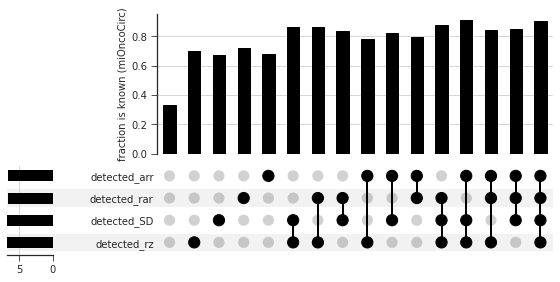

In [45]:

plot(mega.groupby(by = [c for c in mega.columns if c.startswith('detected_')])['is_miOncoCirc'].mean(),
    )
plt.ylabel('fraction is known (miOncoCirc)')
# plt.savefig(figdir / '1_fraction_miOncoCirc.pdf')

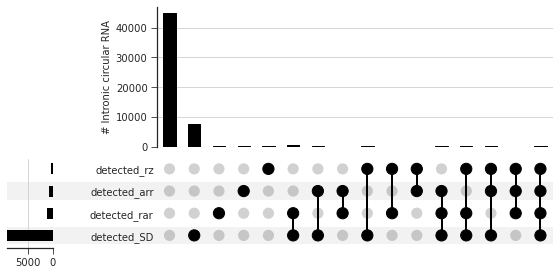

In [46]:

type_cnt = mega.groupby(by = [c for c in mega.columns if c.startswith('detected_')]
            )['circ_type'].value_counts().unstack().fillna(0)
plot(type_cnt['intron'],
    )
plt.ylabel('# Intronic circular RNA')
plt.savefig(figdir / '1_n_intronic.pdf')

# Downsampling

In [47]:
from pathlib import Path
downsample_dir = Path('/tscc/nfs/home/hsher/scratch/downsample_ciri/output/')

In [48]:
data = []
for fname in downsample_dir.glob('*.gtf'):
    name, depth,_ = fname.name.split('.')
    depth = int(depth)
    circ_df, stat = read_ciri_gtf(fname)
    cnt = circ_df['circ_type'].value_counts()
    value = pd.concat([stat.set_index(0)[1], cnt])
    value['name'] = name
    value['depth']=depth
    data.append(value)
data = pd.concat(data, axis =1).T

In [49]:
data[[ '##Total_Reads',
 '##Mapped_Reads',
 '##Circular_Reads']]=data[[ '##Total_Reads',
 '##Mapped_Reads',
 '##Circular_Reads']].astype(int)

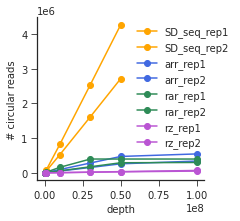

In [50]:
f,ax = plt.subplots(figsize = (3,3))
for name, group in data.sort_values(by = 'depth').groupby(by = 'name'):
    try:
        group.plot(x = 'depth', y = '##Circular_Reads', ax = ax, 
                   label = rename_dict[name], marker = 'o',
                  color =group_color[rename_dict[name].split('_')[0]])
    except:
        group.plot(x = 'depth', y = '##Circular_Reads', ax = ax, 
                   label = name, marker = 'o',
                  color ='grey')
    sns.despine()
ax.set_ylabel('# circular reads')
ax.legend(bbox_to_anchor = (1.2, 1))
plt.savefig(figdir / '1_downsample_n_circ_read.pdf')

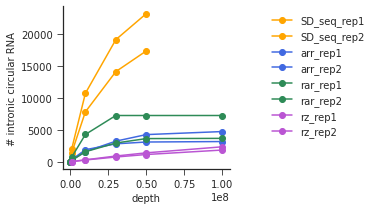

In [51]:
f,ax = plt.subplots(figsize = (3,3))
for name, group in data.sort_values(by = 'depth').groupby(by = 'name'):
    try:
        group.plot(x = 'depth', y = 'intron', ax = ax, 
                   label = rename_dict[name], marker = 'o',
                  color =group_color[rename_dict[name].split('_')[0]])
    except:
        group.plot(x = 'depth', y = 'intron', ax = ax, 
                   label = name, marker = 'o',
                  color ='grey')
    sns.despine()
ax.set_ylabel('# intronic circular RNA')
ax.legend(bbox_to_anchor = (1.2, 1))
plt.savefig(figdir / '1_downsample_n_intronic_circ.pdf')

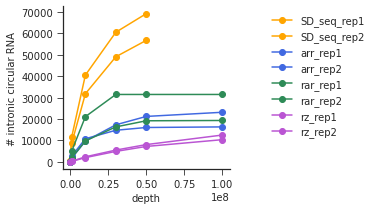

In [52]:
f,ax = plt.subplots(figsize = (3,3))
for name, group in data.sort_values(by = 'depth').groupby(by = 'name'):
    try:
        group.plot(x = 'depth', y = 'exon', ax = ax, 
                   label = rename_dict[name], marker = 'o',
                  color =group_color[rename_dict[name].split('_')[0]])
    except:
        group.plot(x = 'depth', y = 'intron', ax = ax, 
                   label = name, marker = 'o',
                  color ='grey')
    sns.despine()
ax.set_ylabel('# intronic circular RNA')
ax.legend(bbox_to_anchor = (1.2, 1))
plt.savefig(figdir / '1_downsample_n_exon_circ.pdf')

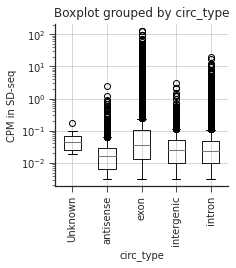

In [53]:
mega.boxplot(by = 'circ_type', column=['SD_seq_rep2'], figsize = (3,3), rot = 90)
plt.yscale('log')
plt.ylabel('CPM in SD-seq')
sns.despine()
plt.title('')
plt.savefig(figdir / '1_CPM_by_type.pdf')

In [54]:
mega['detected_by_other']=mega[[c for c in mega.columns if c.startswith('detected_') and '_SD' not in c]].any(axis = 1)

In [55]:
mega['detected_SD'].value_counts()

False    136355
True      52764
Name: detected_SD, dtype: int64

In [56]:
pd.crosstab(mega['detected_SD'],mega['detected_by_other'])

detected_by_other,False,True
detected_SD,,
False,133102,3253
True,38681,14083


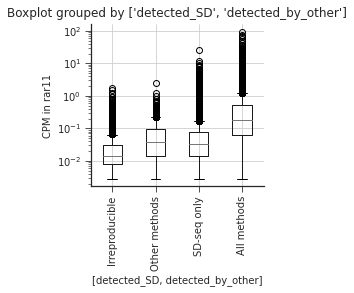

In [57]:
plt.style.use('seaborn-ticks')
mega.boxplot(by = ['detected_SD','detected_by_other'], column = 'SD_seq_rep1', figsize = (3,3),
            rot = 90)
plt.xticks([1,2,3,4],['Irreproducible', 'Other methods', 'SD-seq only', 'All methods'])
sns.despine()
plt.yscale('log')
plt.ylabel('CPM in rar11')
plt.title('')
plt.savefig(figdir / '1_CPM_by_detect_rar11.pdf')

# Are intronic RNA lariats?

In [58]:
gencode_coords = BedTool('/tscc/nfs/home/hsher/gencode_coords/gencode.v35.basic.annotation.gff3')

In [59]:
from collections import defaultdict
known_5ss = defaultdict(set)
known_3ss = defaultdict(set)
for record in gencode_coords:
    if record[2]=='exon':
        gene = record.attrs['gene_name']
        if record.strand == '+':
            ss3 = record.start
            ss5 = record.end+1
        else:
            ss3 = record.end+1
            ss5 = record.start
        known_5ss[gene].add(ss5)
        known_3ss[gene].add(ss3)

In [60]:
intronic = mega.loc[(mega['circ_type']=='intron')&(mega['detected_SD']), 
                   ['seqname', 'start', 'end', 'strand', 'gene_name']]
pos = intronic.loc[intronic['strand']=='+']
neg = intronic.loc[intronic['strand']=='-']
neg['5prime']=neg['end']
neg['3prime']=neg['start']

pos['3prime']=pos['end']
pos['5prime']=pos['start']
intronic = pd.concat([pos, neg], axis = 0)

/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [61]:
intronic['len']= intronic['end']-intronic['start']

In [62]:
intronic

,seqname,start,end,strand,gene_name,3prime,5prime,len
circ_id,,,,,,,,
chr1:1008194|1009370,chr1,1008194.0,1009370.0,+,ISG15,1009370.0,1008194.0,1176.0
chr1:1477849|1478627,chr1,1477849.0,1478627.0,+,ATAD3B,1478627.0,1477849.0,778.0
chr1:1477849|1517294,chr1,1477849.0,1517294.0,+,"AL645728.2,ATAD3A,ATAD3B",1517294.0,1477849.0,39445.0
chr1:1477982|1478627,chr1,1477982.0,1478627.0,+,ATAD3B,1478627.0,1477982.0,645.0
chr1:2055441|2059591,chr1,2055441.0,2059591.0,+,PRKCZ,2059591.0,2055441.0,4150.0
...,...,...,...,...,...,...,...,...
chrX:154092184|154092482,chrX,154092184.0,154092482.0,-,MECP2,154092184.0,154092482.0,298.0
chrX:154788027|154792285,chrX,154788027.0,154792285.0,-,MPP1,154788027.0,154792285.0,4258.0
chrX:155506898|155537118,chrX,155506898.0,155537118.0,-,TMLHE,155506898.0,155537118.0,30220.0


In [63]:
intronic['hit_5ss']=intronic.apply(lambda row: int(row['5prime']) in known_5ss[row['gene_name']], axis = 1)

In [64]:
intronic['hit_5ss'].value_counts()

False    8503
True      536
Name: hit_5ss, dtype: int64

In [65]:
476/(7339+476)

0.06090850927703135

In [66]:
def closest_upstream_5ss(row):
    ss5_list = list(known_5ss[row['gene_name']])
    
    # if not ss5_list:
    #     return np.nan
    
    if row['strand']=='+':
        
        dist = [row['5prime']-s for s in ss5_list if row['5prime']-s >= 0]
        try:
            return min(dist)
        except:
            return np.nan
    else:
        dist = [row['5prime']-s for s in ss5_list if row['5prime']-s <= 0]
        try:
            return -max(dist)
        except:
            return np.nan

In [67]:
def closest_downstream_3ss(row):
    ss3_list = list(known_3ss[row['gene_name']])
    
    # if not ss5_list:
    #     return np.nan
    
    if row['strand']=='+':
        
        dist = [row['3prime']-s for s in ss3_list if row['3prime']-s <= 0]
        try:
            return -max(dist)
        except:
            return np.nan
    else:
        dist = [row['3prime']-s for s in ss3_list if row['3prime']-s >= 0]
        try:
            return min(dist)
        except:
            return np.nan

In [68]:
intronic['distance_to_closest_upstream_5ss']=intronic.apply(lambda row: closest_upstream_5ss(row), axis = 1)

<AxesSubplot:>

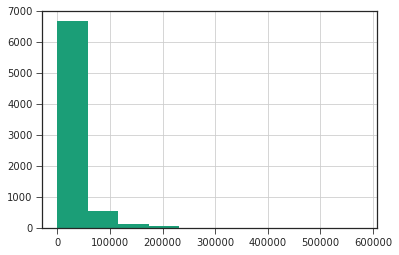

In [69]:
intronic['distance_to_closest_upstream_5ss'].hist()

In [70]:
intronic['distance_to_closest_downstream_3ss']=intronic.apply(lambda row: closest_downstream_3ss(row), axis = 1)

Text(0, 0.5, '# intronic circle')

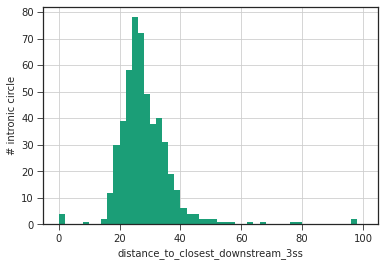

In [71]:
intronic.loc[intronic['hit_5ss'], 'distance_to_closest_downstream_3ss'].hist(range = (0,100),
                                                                            bins = 50)
plt.xlabel('distance_to_closest_downstream_3ss')
plt.ylabel('# intronic circle')

In [72]:
intronic.loc[intronic['distance_to_closest_downstream_3ss']<0]

,seqname,start,end,strand,gene_name,3prime,5prime,len,hit_5ss,distance_to_closest_upstream_5ss,distance_to_closest_downstream_3ss
circ_id,,,,,,,,,,,


In [73]:
intronic.loc[intronic['distance_to_closest_downstream_3ss']==0]

,seqname,start,end,strand,gene_name,3prime,5prime,len,hit_5ss,distance_to_closest_upstream_5ss,distance_to_closest_downstream_3ss
circ_id,,,,,,,,,,,
chr6:135038032|135042126,chr6,135038032.0,135042126.0,-,HBS1L,135038032.0,135042126.0,4094.0,False,8455.0,0.0
chr6:135038032|135050647,chr6,135038032.0,135050647.0,-,HBS1L,135038032.0,135050647.0,12615.0,False,4001.0,0.0


In [74]:
lariat=intronic.loc[intronic['hit_5ss']]

In [75]:
mega.loc[lariat.index]['detected_arr'].sum(),
mega.loc[lariat.index]['detected_arr'].sum(),

(0,)

In [76]:
lariat.shape

(536, 11)

Text(0, 0.5, '# intronic circle')

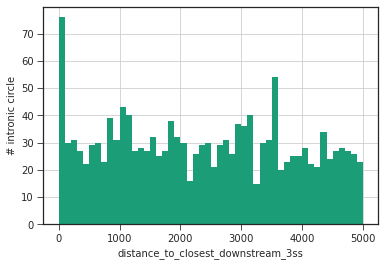

In [77]:
intronic.loc[~intronic['hit_5ss'], 'distance_to_closest_downstream_3ss'].hist(range = (0,5000),
                                                                            bins = 50)
plt.xlabel('distance_to_closest_downstream_3ss')
plt.ylabel('# intronic circle')

Text(0, 0.5, '# intronic circle')

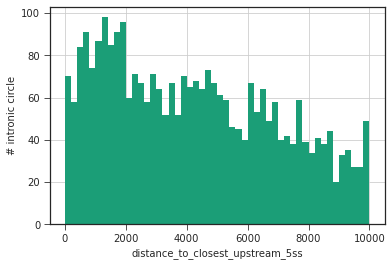

In [78]:
intronic.loc[~intronic['hit_5ss'], 'distance_to_closest_upstream_5ss'].hist(range = (0,10000),
                                                                            bins = 50)
plt.xlabel('distance_to_closest_upstream_5ss')
plt.ylabel('# intronic circle')

In [79]:
intronic.loc[(intronic['distance_to_closest_downstream_3ss']<50)&
            ~intronic['hit_5ss']]

,seqname,start,end,strand,gene_name,3prime,5prime,len,hit_5ss,distance_to_closest_upstream_5ss,distance_to_closest_downstream_3ss
circ_id,,,,,,,,,,,
chr1:1477849|1478627,chr1,1477849.0,1478627.0,+,ATAD3B,1478627.0,1477849.0,778.0,False,498.0,16.0
chr1:1477982|1478627,chr1,1477982.0,1478627.0,+,ATAD3B,1478627.0,1477982.0,645.0,False,631.0,16.0
chr1:12303877|12304483,chr1,12303877.0,12304483.0,+,VPS13D,12304483.0,12303877.0,606.0,False,4492.0,22.0
chr1:119146359|119150746,chr1,119146359.0,119150746.0,+,WARS2-AS1,119150746.0,119146359.0,4387.0,False,4545.0,46.0
chr1:154251041|154257301,chr1,154251041.0,154257301.0,+,UBAP2L,154257301.0,154251041.0,6260.0,False,1603.0,44.0
chr1:160353502|160354093,chr1,160353502.0,160354093.0,+,NCSTN,160354093.0,160353502.0,591.0,False,264.0,24.0
chr1:212071277|212072074,chr1,212071277.0,212072074.0,+,DTL,212072074.0,212071277.0,797.0,False,2573.0,26.0
chr3:18027397|18041541,chr3,18027397.0,18041541.0,+,AC132807.2,18041541.0,18027397.0,14144.0,False,10685.0,46.0
chr3:39390497|39391396,chr3,39390497.0,39391396.0,+,SLC25A38,39391396.0,39390497.0,899.0,False,880.0,44.0


# visualize circles

In [80]:
bsj

index,SD_seq_rep1,SD_seq_rep2,arr_rep2,arr_rep1,rar_rep2,rz_rep2,rar_rep1,rz_rep1
circ_id,,,,,,,,
chr1:633563|634095,42.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN
chr1:746695|749381,344.0,285.0,NaN,NaN,25.0,NaN,NaN,NaN
chr1:801109|810170,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr1:805799|810170,202.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN
chr1:925922|943828,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
chrX:154351884|154352447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
chrX:154413207|154413567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
chrX:154442907|154443069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [81]:
bsj.loc[bsj['SD_seq_rep1']>10]

index,SD_seq_rep1,SD_seq_rep2,arr_rep2,arr_rep1,rar_rep2,rz_rep2,rar_rep1,rz_rep1
circ_id,,,,,,,,
chr1:633563|634095,42.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN
chr1:746695|749381,344.0,285.0,NaN,NaN,25.0,NaN,NaN,NaN
chr1:805799|810170,202.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN
chr1:935772|939412,15.0,38.0,2.0,NaN,NaN,NaN,8.0,7.0
chr1:935772|939460,308.0,266.0,43.0,68.0,155.0,8.0,46.0,NaN
...,...,...,...,...,...,...,...,...
chrX:155506898|155545277,56.0,137.0,3.0,NaN,4.0,NaN,NaN,NaN
chrX:155511673|155514265,19.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
chrX:155524456|155545277,71.0,75.0,NaN,NaN,8.0,NaN,1.0,NaN


In [82]:
circ_id='chr8:141253989|141254629' 	
region = circ_id.replace('|', '-')
print('module load samtools')
bams = ['/tscc/nfs/home/hsher/scratch/circ_truseq/output/align/circseq-bm-arr.sorted.bam',
'/tscc/nfs/home/hsher/scratch/circ_truseq/output/align/circseq-bm-rar.sorted.bam',
'/tscc/nfs/home/hsher/scratch/circ_truseq/output/align/circseq-bm-rz.sorted.bam',
'/tscc/nfs/home/hsher/scratch/circ_nextera/output/align/circseq-bm-rar11-nxt.sorted.bam']
outf = '/tscc/nfs/home/hsher/scratch/visualize_circle/'
print(f'mkdir {outf}')
for b in bams:
    fname = Path(b).name.split('.')[0]
    print(f'samtools view -b {b} {region} > {outf}/{fname}.{region}.bam')
    print(f'samtools index {outf}/{fname}.{region}.bam')

module load samtools
mkdir /tscc/nfs/home/hsher/scratch/visualize_circle/
samtools view -b /tscc/nfs/home/hsher/scratch/circ_truseq/output/align/circseq-bm-arr.sorted.bam chr8:141253989-141254629 > /tscc/nfs/home/hsher/scratch/visualize_circle//circseq-bm-arr.chr8:141253989-141254629.bam
samtools index /tscc/nfs/home/hsher/scratch/visualize_circle//circseq-bm-arr.chr8:141253989-141254629.bam
samtools view -b /tscc/nfs/home/hsher/scratch/circ_truseq/output/align/circseq-bm-rar.sorted.bam chr8:141253989-141254629 > /tscc/nfs/home/hsher/scratch/visualize_circle//circseq-bm-rar.chr8:141253989-141254629.bam
samtools index /tscc/nfs/home/hsher/scratch/visualize_circle//circseq-bm-rar.chr8:141253989-141254629.bam
samtools view -b /tscc/nfs/home/hsher/scratch/circ_truseq/output/align/circseq-bm-rz.sorted.bam chr8:141253989-141254629 > /tscc/nfs/home/hsher/scratch/visualize_circle//circseq-bm-rz.chr8:141253989-141254629.bam
samtools index /tscc/nfs/home/hsher/scratch/visualize_circle//circseq-b

In [83]:
region

'chr8:141253989-141254629'

In [84]:
pd.Series(bsj.index).apply(lambda x: int(x.split('|')[1])-int(x.split('|')[0].split(':')[1]))

0           532
1          2686
2          9061
3          4371
4         17906
          ...  
189114      563
189115      360
189116      162
189117     8461
189118     7024
Name: circ_id, Length: 189119, dtype: int64

In [85]:
bsj.loc[(bsj/(fsj+1)).sort_values(by = 'SD_seq_rep1', ascending = False).iloc[:50].index]

index,SD_seq_rep1,SD_seq_rep2,arr_rep2,arr_rep1,rar_rep2,rz_rep2,rar_rep1,rz_rep1
circ_id,,,,,,,,
chr5:137985257|137988315,33508.0,29217.0,101.0,186.0,289.0,32.0,187.0,67.0
chr18:21765772|21779685,17845.0,38134.0,1022.0,2074.0,NaN,73.0,469.0,128.0
chr5:170878097|170896115,15305.0,22244.0,126.0,359.0,NaN,2.0,70.0,16.0
chr3:158122103|158123991,12737.0,11291.0,70.0,77.0,NaN,32.0,NaN,23.0
chr3:170145423|170149244,12179.0,14782.0,4.0,5.0,NaN,2.0,111.0,NaN
chr6:4891713|4892379,10679.0,21374.0,NaN,NaN,NaN,125.0,187.0,49.0
chr7:129014979|129018157,9992.0,15480.0,252.0,NaN,NaN,20.0,140.0,44.0
chr9:20819796|20823115,9948.0,14031.0,91.0,419.0,187.0,13.0,73.0,15.0
chr4:185247294|185267155,9302.0,13813.0,312.0,511.0,434.0,35.0,158.0,35.0


In [86]:
bsj.loc['chr18:21765772|21779685']

index
SD_seq_rep1    17845.0
SD_seq_rep2    38134.0
arr_rep2        1022.0
arr_rep1        2074.0
rar_rep2           NaN
rz_rep2           73.0
rar_rep1         469.0
rz_rep1          128.0
Name: chr18:21765772|21779685, dtype: float64

In [87]:
bsj['length']=pd.Series(bsj.index).apply(lambda x: int(x.split('|')[1])-int(x.split('|')[0].split(':')[1])).tolist()

In [88]:
bsj.loc['chr9:131506114|131506453']

index
SD_seq_rep1    9107.0
SD_seq_rep2    6161.0
arr_rep2          6.0
arr_rep1          NaN
rar_rep2         56.0
rz_rep2           7.0
rar_rep1         57.0
rz_rep1           1.0
length          339.0
Name: chr9:131506114|131506453, dtype: float64